In [1]:
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"
sys.path.append(str(src_path))

import data_preprocessing as dp
import model_evaluation as me

In [2]:
import pandas as pd
import numpy as np
import random

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

import seaborn as sns
import matplotlib.pyplot as plt


In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dropout, Activation, Bidirectional
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier

In [4]:
sns.set(context = 'notebook', style = 'whitegrid')

# get data using andrew's clean data functions

In [5]:
csv_path = data_path / 'targeted_combined_no_lem.csv'
cleaned_df = pd.read_csv(csv_path)

In [6]:
cleaned_df.dropna(inplace=True)

In [7]:
cleaned_df.head(5)

,emotion,txt_cleaned
0,0.0,product_target hrs tweeting riseaustin dead ne...
1,2.0,know awesome ipadiphone product_target youll l...
2,2.0,wait product_target also sale sxsw
3,0.0,hope years festival isnt crashy years iphone p...
4,2.0,great stuff fri sxsw marissa mayer product_tar...


In [8]:
y = cleaned_df['emotion']
y

0        0.0
1        2.0
2        2.0
3        0.0
4        2.0
        ... 
22601    0.0
22602    0.0
22603    0.0
22604    0.0
22605    0.0
Name: emotion, Length: 22606, dtype: float64

In [9]:
X = cleaned_df['txt_cleaned']
X

0        product_target hrs tweeting riseaustin dead ne...
1        know awesome ipadiphone product_target youll l...
2                       wait product_target also sale sxsw
3        hope years festival isnt crashy years iphone p...
4        great stuff fri sxsw marissa mayer product_tar...
                               ...                        
22601    literally reason want go rest line kind snooze...
22602                          anyone else completely sold
22603                         recycled fuck product_target
22604                    line already fake like every year
22605                                        fersure thing
Name: txt_cleaned, Length: 22606, dtype: object

In [10]:
y.value_counts()

2.0    8213
0.0    8062
1.0    6331
Name: emotion, dtype: int64

In [11]:
X.isna().value_counts()

False    22606
Name: txt_cleaned, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train, test_size=.1)

# tokenize tweets

In [13]:
X_train_list = list(X_train)
X_test_list = list(X_test)
X_tr_list = list(X_tr)
X_v_list = list(X_v)

X_train_corpus = []
X_tr_corpus = []
for tweet in X_train_list:
    X_train_corpus.extend(tweet.split(' '))
for tweet in X_tr_list:
    X_tr_corpus.extend(tweet.split(' '))
    
X_train_unique = len(set(X_train_corpus))
X_tr_unique = len(set(X_tr_corpus))

In [14]:
sequence_length = 100

partial_tokenizer = text.Tokenizer(num_words=X_tr_unique)
full_tokenizer = text.Tokenizer(num_words=X_train_unique)

partial_tokenizer.fit_on_texts(X_tr_list)
full_tokenizer.fit_on_texts(X_train_list)

X_tr_tokenized = partial_tokenizer.texts_to_sequences(X_tr_list)
X_v_tokenized = partial_tokenizer.texts_to_sequences(X_v_list)
X_train_tokenized= full_tokenizer.texts_to_sequences(X_train_list)
X_test_tokenized= full_tokenizer.texts_to_sequences(X_test_list)

X_tr_tokens = sequence.pad_sequences(X_tr_tokenized, maxlen=sequence_length)
X_v_tokens = sequence.pad_sequences(X_v_tokenized, maxlen=sequence_length)
X_train_tokens = sequence.pad_sequences(X_train_tokenized, maxlen=sequence_length)
X_test_tokens = sequence.pad_sequences(X_test_tokenized, maxlen=sequence_length)

#### ^^^ modified for train_test_split variables up to here

# construct CNN with embedding layer

In [15]:
partial_model = Sequential()

embedding_size = 64
partial_model.add(Embedding(input_dim=len(set(X_tr_corpus)), output_dim=embedding_size, input_length=sequence_length))
partial_model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
partial_model.add(Dropout(0.7))
partial_model.add(MaxPooling1D(pool_size=3))
partial_model.add(Flatten())
partial_model.add(Dense(units=30, activation='tanh'))
partial_model.add(Dropout(.5))
partial_model.add(Dense(units=10, activation='tanh'))
partial_model.add(Dropout(.5))
partial_model.add(Dense(units=3, activation='softmax'))
partial_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model on tokenized data

In [16]:
partial_model.fit(X_tr_tokens, pd.get_dummies(y_tr), validation_data=(X_v_tokens, pd.get_dummies(y_v)), epochs=10, batch_size=512)

Epoch 1/10
32/32 [==============================] - 4s 131ms/step - loss: 1.0924 - accuracy: 0.3773 - val_loss: 1.0948 - val_accuracy: 0.3648
Epoch 2/10
32/32 [==============================] - 4s 111ms/step - loss: 1.0429 - accuracy: 0.4629 - val_loss: 0.9916 - val_accuracy: 0.4997
Epoch 3/10
32/32 [==============================] - 3s 101ms/step - loss: 0.9078 - accuracy: 0.5672 - val_loss: 0.8885 - val_accuracy: 0.6086
Epoch 4/10
32/32 [==============================] - 3s 101ms/step - loss: 0.7760 - accuracy: 0.6632 - val_loss: 0.8525 - val_accuracy: 0.6224
Epoch 5/10
32/32 [==============================] - 3s 100ms/step - loss: 0.6437 - accuracy: 0.7433 - val_loss: 0.8271 - val_accuracy: 0.6473
Epoch 6/10
32/32 [==============================] - 3s 101ms/step - loss: 0.5290 - accuracy: 0.8025 - val_loss: 0.8467 - val_accuracy: 0.6363
Epoch 7/10
32/32 [==============================] - 3s 100ms/step - loss: 0.4512 - accuracy: 0.8404 - val_loss: 0.8918 - val_accuracy: 0.6247
Epoch 

In [29]:
plot_confusion_matrix()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


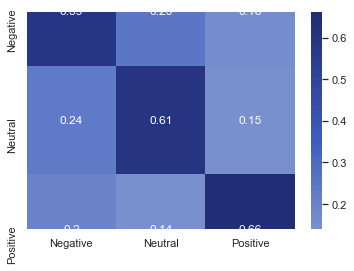

In [17]:
me.plot_confusion_matrix(y_v, np.argmax(partial_model.predict(X_v_tokens), axis=1))

In [18]:
confusion_matrix(y_v, np.argmax(partial_model.predict(X_v_tokens), axis=1))

array([[383, 164, 105],
       [118, 299,  74],
       [132,  93, 441]])

# train model on full train split for validation on 'test'

In [34]:
def make_CNN():
    model = Sequential()

    embedding_size = 64
    model.add(Embedding(input_dim=len(set(X_train_corpus)), output_dim=embedding_size, input_length=sequence_length))
    model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
    model.add(Dropout(0.7))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(units=30, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=10, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

final_model = KerasClassifier(make_CNN, epochs=5, batch_size=512)

In [35]:
final_model.fit(X_train_tokens, pd.get_dummies(y_train))

Epoch 1/5
36/36 [==============================] - 5s 128ms/step - loss: 1.0922 - accuracy: 0.3726
Epoch 2/5
36/36 [==============================] - 4s 111ms/step - loss: 1.0289 - accuracy: 0.4672
Epoch 3/5
36/36 [==============================] - 4s 110ms/step - loss: 0.8841 - accuracy: 0.5983
Epoch 4/5
36/36 [==============================] - 4s 109ms/step - loss: 0.7449 - accuracy: 0.6945
Epoch 5/5
36/36 [==============================] - 4s 106ms/step - loss: 0.6140 - accuracy: 0.7632


# use this matrix below

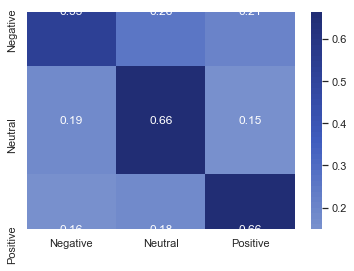

In [38]:
me.plot_confusion_matrix(y_test, final_model.predict(X_test_tokens))

In [40]:
confusion_matrix(y_test, final_model.predict(X_test_tokens))

array([[ 853,  419,  336],
       [ 244,  866,  194],
       [ 253,  287, 1070]])